In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from preprocess import tokenize_raw_text
from unigram import UnigramCounter, UnigramModel

In [3]:
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Arc
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 10

legend_opts = {
    'fontsize':15,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}

def savefig(fig, filename, **kwargs):
    fig.savefig(f'../viz/{filename}', bbox_inches='tight', **kwargs)

## Tokenize texts

In [4]:
tokenize_raw_text('../data/train_raw.txt', '../data/train_tokenized.txt')
tokenize_raw_text('../data/dev1_raw.txt', '../data/dev1_tokenized.txt')
tokenize_raw_text('../data/dev2_raw.txt', '../data/dev2_tokenized.txt')

## Count ngrams in text

In [5]:
train_counter = UnigramCounter('../data/train_tokenized.txt')
dev1_counter = UnigramCounter('../data/dev1_tokenized.txt')
dev2_counter = UnigramCounter('../data/dev2_tokenized.txt')

In [6]:
train_counter.token_count, dev1_counter.token_count, dev2_counter.token_count

(321468, 353110, 450066, 461331, 333851)

## Unigram model

In [7]:
train_model = UnigramModel(train_counter)
train_model.train(k=1)

In [8]:
dev1_avg_log_likelihood = train_model.evaluate(dev1_counter)
dev2_avg_log_likelihood = train_model.evaluate(dev2_counter)
print(dev1_avg_log_likelihood)
print(dev2_avg_log_likelihood)

-9.507387648094397
-10.168088076101292


### Visualization of smoothing

In [9]:
train_model = UnigramModel(train_counter)
train_model.train(k=0)
train_percents_k0 = {unigram:prob*100 for unigram, prob in sorted(train_model.probs.items(), key=lambda item: item[1], reverse=True)}
train_model.train(k=1)
train_percents_k1 = {unigram:prob*100 for unigram, prob in sorted(train_model.probs.items(), key=lambda item: item[1], reverse=True)}

In [10]:
top_unigrams0, top_percents0 = list(train_percents_k0.keys())[:10], list(train_percents_k0.values())[:10]
top_unigrams1, top_percents1 = list(train_percents_k1.keys())[:10], list(train_percents_k1.values())[:10]
bottom_unigrams0, bottom_percents0 = list(train_percents_k0.keys())[-10:], list(train_percents_k0.values())[-10:]
bottom_unigrams1, bottom_percents1 = list(train_percents_k1.keys())[-10:], list(train_percents_k1.values())[-10:]

In [11]:
def evaluate(self, evaluation_counter: UnigramCounter) -> float:
    """
    Calculate the average log likelihood of the model on the evaluation text
    :param evaluation_counter: unigram counter for the text on which the model is evaluated on
    :return: average log likelihood that the unigram model assigns to the evaluation text
    """
    test_log_likelihood = 0
    test_counts = evaluation_counter.counts

    for unigram, test_count in test_counts.items():
        if unigram not in self.vocab:
            unigram = '[UNK]'
        train_prob = self.probs[unigram]
        log_likelihood = test_count * log2(train_prob)
        test_log_likelihood += log_likelihood

    avg_test_log_likelihood = test_log_likelihood / evaluation_counter.token_count
    return avg_test_log_likelihood

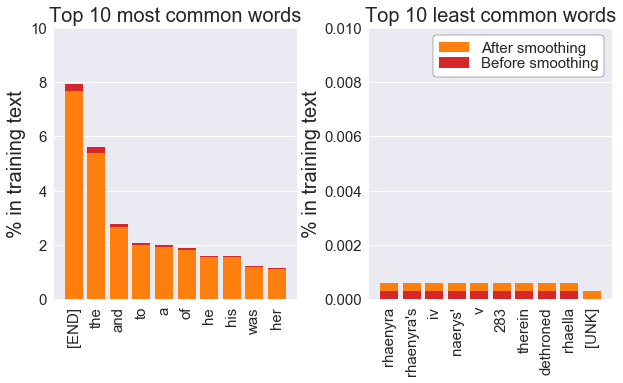

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3)
ax_top = ax[0]
ax_top.bar(range(len(top_unigrams0)), top_percents0, color='tab:red')
ax_top.bar(range(len(top_unigrams1)), top_percents1, color='tab:orange')
ax_top.set_xticks(range(len(top_unigrams0)))
ax_top.set_xticklabels(top_unigrams0, rotation=90)
ax_top.set_ylim(0, 10)
ax_top.set_ylabel('% in training text')
ax_top.set_title('Top 10 most common words')
ax_top.grid(b=None, axis='x')

ax_bottom = ax[1]
ax_bottom.bar(range(len(bottom_unigrams1)), bottom_percents1, color='tab:orange', label='After smoothing')
ax_bottom.bar(range(len(bottom_unigrams0)), bottom_percents0, color='tab:red', label='Before smoothing')
ax_bottom.set_xticks(range(len(bottom_unigrams0)))
ax_bottom.set_xticklabels(bottom_unigrams0, rotation=90)
ax_bottom.set_ylim(0, 0.01)
ax_bottom.set_ylabel('% in training text')
ax_bottom.grid(b=None, axis='x')
ax_bottom.set_title('Top 10 least common words')
ax_bottom.legend(**legend_opts)

savefig(fig, 'smoothing_common_words.png')

### Comparing unigram distribution

In [13]:
train_model_smoothed = UnigramModel(train_counter)
train_model_smoothed.train(k=1)

dev1_model_unsmoothed = UnigramModel(dev1_counter)
dev1_model_unsmoothed.train(k=0)

dev2_model_unsmoothed = UnigramModel(dev2_counter)
dev2_model_unsmoothed.train(k=0)

In [14]:
sorted_train_unigrams = []
sorted_train_unigram_percents = []

for ngram, ngram_prob in sorted(train_model_smoothed.probs.items(), key=lambda item: item[1], reverse=True):
    sorted_train_unigrams.append(ngram)
    sorted_train_unigram_percents.append(ngram_prob*100)

In [15]:
def calculate_k_from_unigram_weight(unigram_weight, token_count, vocab_size):
    nom = token_count - token_count * unigram_weight
    denom = vocab_size * unigram_weight
    return nom / denom

In [16]:
train_model_unsmoothed = UnigramModel(train_counter)
train_model_unsmoothed.train(k=0)

train_model_smoothed_80_20 = UnigramModel(train_counter)
k_80_20 = calculate_k_from_unigram_weight(0.8, train_counter.token_count, train_model.vocab_size)
train_model_smoothed_80_20.train(k=k_80_20)

In [17]:
dev1_unigram_percents = [dev1_model_unsmoothed.probs.get(unigram, 0)*100 for unigram in sorted_train_unigrams]
dev2_unigram_percents = [dev2_model_unsmoothed.probs.get(unigram, 0)*100 for unigram in sorted_train_unigrams]
train_unsmoothed_unigram_percents = [train_model_unsmoothed.probs.get(unigram, 0)*100 for unigram in sorted_train_unigrams]
train_80_20_unigram_percents = [train_model_smoothed_80_20.probs.get(unigram, 0)*100 for unigram in sorted_train_unigrams]

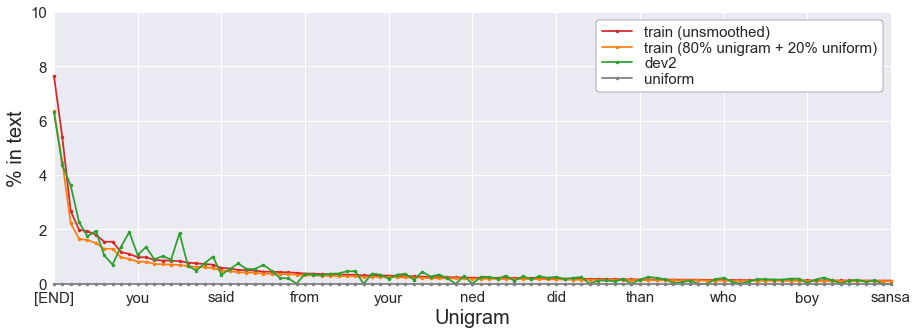

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
xlim = 101
ax.plot(np.array(sorted_train_unigram_percents[:xlim]), '.-', label='train (unsmoothed)', color='tab:red', clip_on=False)
ax.plot(np.array(train_80_20_unigram_percents[:xlim]), '.-', label='train (80% unigram + 20% uniform)', color='tab:orange', clip_on=False)
# ax.plot(np.array(sorted_train_unigram_percents[:xlim]), '.-', label='train (add-one smoothing)', color='tab:red', clip_on=False)
# ax.plot(np.array(dev1_unigram_percents[:xlim]), '.-', label='dev1', color='tab:blue', clip_on=False)
ax.plot(np.array(dev2_unigram_percents[:xlim]), '.-', label='dev2', color='tab:green', clip_on=False)
ax.plot([1/train_model.vocab_size]*xlim, '.-', label='uniform', color='tab:gray', clip_on=False)


xticks = range(0, xlim+1, 10)
xticklabels = np.array(sorted_train_unigrams)[xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.legend(**legend_opts)
ax.set_xlim(0, xlim-1)
ax.set_ylim(0, 10)
ax.set_xlabel('Unigram')
ax.set_ylabel('% in text')

savefig(fig, 'train_80_20.png')

### Varying interpolation weights

In [19]:
unigram_weights = np.linspace(0.0001, 1-0.0001, 100)

In [20]:
ks = calculate_k_from_unigram_weight(unigram_weights, train_counter.token_count, train_model.vocab_size)

In [21]:
train_avg_lls, dev1_avg_lls, dev2_avg_lls = [], [], []
for k in ks:
    train_model.train(k)
    train_avg_lls.append(train_model.evaluate(train_counter))
    dev1_avg_lls.append(train_model.evaluate(dev1_counter))
    dev2_avg_lls.append(train_model.evaluate(dev2_counter))

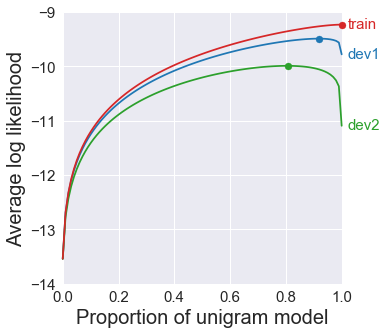

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(unigram_weights, dev1_avg_lls, color='tab:blue', clip_on=False)
ax.plot(unigram_weights, dev2_avg_lls, color='tab:green', clip_on=False)
ax.plot(unigram_weights, train_avg_lls, color='tab:red', clip_on=False)

ax.scatter(unigram_weights[np.argmax(train_avg_lls)], np.max(train_avg_lls), color='tab:red', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev1_avg_lls)], np.max(dev1_avg_lls), color='tab:blue', clip_on=False)
ax.scatter(unigram_weights[np.argmax(dev2_avg_lls)], np.max(dev2_avg_lls), color='tab:green', clip_on=False)

ax.text(1.02, train_avg_lls[-1], s='train', va='center', color='tab:red', fontsize=15)
ax.text(1.02, dev1_avg_lls[-1], s='dev1', va='center', color='tab:blue', fontsize=15)
ax.text(1.02, dev2_avg_lls[-1], s='dev2', va='center', color='tab:green', fontsize=15)

ax.set_xlim(0, 1)
ax.set_ylim(-14, -9)
ax.set_xlabel('Proportion of unigram model')
ax.set_ylabel('Average log likelihood')

savefig(fig, 'proportion_vs_ll.png')